In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src import config

folder_path = config.YAHOO_DATA_DIR
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]


test_data = pd.read_csv(os.path.join(folder_path, all_files[0]))
print(test_data.head())


         Date     Close      High       Low      Open   Volume  Log_Return
0  2024-01-01  0.003734  0.003809  0.003549  0.003678  9169185         NaN
1  2024-01-02  0.003706  0.003780  0.003660  0.003734  6344244   -0.007527
2  2024-01-03  0.003374  0.003740  0.003322  0.003705  8036622   -0.093854
3  2024-01-04  0.003450  0.003458  0.003327  0.003375  5588532    0.022275
4  2024-01-05  0.003270  0.003451  0.003206  0.003449  6058802   -0.053584


In [4]:
test_data = test_data.iloc[:-2]
print(test_data.head())

         Date     Close      High       Low      Open   Volume  Log_Return
0  2024-01-01  0.003734  0.003809  0.003549  0.003678  9169185         NaN
1  2024-01-02  0.003706  0.003780  0.003660  0.003734  6344244   -0.007527
2  2024-01-03  0.003374  0.003740  0.003322  0.003705  8036622   -0.093854
3  2024-01-04  0.003450  0.003458  0.003327  0.003375  5588532    0.022275
4  2024-01-05  0.003270  0.003451  0.003206  0.003449  6058802   -0.053584


In [ ]:
for file in all_files:
    try:
        data = pd.read_csv(os.path.join(folder_path, file))
        # Remove the last two row which is often incomplete
        if not data.empty:
            data = data.iloc[:-2]
            data.to_csv(os.path.join(folder_path, file))
    except Exception as e:
        print(f"Could not process file {file}: {e}")

In [5]:
import requests
import pandas as pd

def check_ticker(coin_id):
    url = f"https://finance.yahoo.com/quote/{coin_id.upper()}-USD"
    return requests.get(url).status_code == 200

df = pd.read_csv(config.GECKO_TICKERS_FILE)  # column: 'id'
mapped, unmapped = [], []

for coin in df["coin_id"]:
    ticker = f"{coin.upper()}-USD"
    if check_ticker(coin):
        mapped.append({"coin_id": coin, "yahoo_ticker": ticker})
    else:
        unmapped.append(coin)

# pd.DataFrame(mapped).to_csv("mapped.csv", index=False)
# pd.DataFrame(unmapped, columns=["coin_id"]).to_csv("unmapped.csv", index=False)
print(mapped)

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[]


In [10]:
import requests
import pandas as pd
from datetime import datetime

def get_ohlcv_history(coin_id, days='365'):
    """
    Fetches historical OHLCV (Open, High, Low, Close, Volume) data for a given coin from CoinGecko.
    The 'days' parameter can be an integer (e.g., '30', '90', '365') or 'max'.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        # Extract prices and volume
        prices = data.get('prices', [])
        total_volumes = data.get('total_volumes', [])

        if not prices or not total_volumes:
            return None

        # Build base DataFrame
        df = pd.DataFrame({
            'date': pd.to_datetime([p[0] for p in prices], unit='ms').normalize(),
            'close': [p[1] for p in prices],
            'volume': [v[1] for v in total_volumes]
        })

        # Sort by date just in case
        df = df.sort_values('date').reset_index(drop=True)

        df['coin_id'] = coin_id

        # Remove today's partial data if present
        if df['date'].iloc[-1].date() == datetime.utcnow().date():
            df = df.iloc[:-1]

        return df[['date', 'coin_id', 'close', 'volume']]

    except Exception as e:
        print(f"Error fetching data for {coin_id}: {e}")
        return None

In [11]:
test_data = get_ohlcv_history('bitcoin')
print(test_data.head())

        date  coin_id         close        volume
0 2024-06-28  bitcoin  61562.645326  1.885514e+10
1 2024-06-29  bitcoin  60317.096979  2.439942e+10
2 2024-06-30  bitcoin  60864.443162  1.143511e+10
3 2024-07-01  bitcoin  62734.393839  1.737359e+10
4 2024-07-02  bitcoin  62819.822269  2.557307e+10


In [6]:
# Cell 1: Setup, Imports, and Helper Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import os
import sys

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Add the project root to the Python path to allow imports from src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import config
import pandas_datareader.data as web

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported and configuration loaded.")

def get_risk_free_rate(start_date, end_date):
    """Fetches the 3-Month Treasury Bill Rate from FRED as the risk-free rate."""
    try:
        rf = web.DataReader('DTB3', 'fred', start_date, end_date)
        rf = rf.ffill() / 100 / 360
        return rf
    except Exception as e:
        return pd.Series(0, index=pd.date_range(start=start_date, end=end_date), name='DTB3')

# Cell 2: (Part 1) Load and Prepare Data

print("--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---")
print("\nLoading data...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Original 3-factor dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Prepare data for regression
full_df_orig = index_df.join(features_df, how='inner')
full_df_orig['pca_return'] = np.log(full_df_orig['Value']).diff()
rf_rate = get_risk_free_rate(full_df_orig.index.min(), full_df_orig.index.max())
full_df_orig['rf_rate'] = rf_rate['DTB3'].reindex(full_df_orig.index, method='ffill').fillna(0)
full_df_orig['pca_excess_return'] = full_df_orig['pca_return'] - full_df_orig['rf_rate']
full_df_orig.dropna(inplace=True)

# Define X, y and the CV strategy
X_orig = full_df_orig[['MKT', 'SMB', 'WML']]
y_orig = full_df_orig['pca_excess_return']
tscv = TimeSeriesSplit(n_splits=5)

# Scale features for relevant models
scaler_orig = StandardScaler()
X_orig_scaled = scaler_orig.fit_transform(X_orig)

print("Data for Part 1 is prepared.")

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported and configuration loaded.
--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---

Loading data...
Original 3-factor dataset loaded successfully.
Data for Part 1 is prepared.


In [14]:
import numpy as np

pca_index_data = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
pca_index_data['log_return'] = np.log(pca_index_data['Value'] / pca_index_data['Value'].shift(1))
print(pca_index_data.head())

                  Value  log_return
Date                               
2024-05-28  1000.000000         NaN
2024-05-29   988.448863   -0.011618
2024-05-30   974.915221   -0.013786
2024-05-31   977.997462    0.003157
2024-06-01   972.938874   -0.005186


In [57]:
rf_rate = get_risk_free_rate(pca_index_data.index.min(), pca_index_data.index.max())
print(pca_index_data.index.min())
print(rf_rate.head())
# Align risk-free rate with our data's dates
rf = rf_rate['DTB3'].reindex(pca_index_data.index, method='ffill')
print(rf.head())
# Market return is the equal-weighted average of all crypto returns
market_return = pca_index_data['log_return']
mkt = market_return - rf
print(mkt.head())


Fetching risk-free rate from FRED...
2024-05-28 00:00:00
                DTB3
DATE                
2024-05-28  0.000146
2024-05-29  0.000146
2024-05-30  0.000146
2024-05-31  0.000146
2024-06-03  0.000146
Date
2024-05-28    0.000146
2024-05-29    0.000146
2024-05-30    0.000146
2024-05-31    0.000146
2024-06-01    0.000146
Name: DTB3, dtype: float64
Date
2024-05-28         NaN
2024-05-29   -0.011764
2024-05-30   -0.013933
2024-05-31    0.003011
2024-06-01   -0.005332
dtype: float64


In [58]:
daily_return_data = pd.read_csv(config.DAILY_RETURN_FILE_PATH, index_col='Date', parse_dates=True)
market_cap_data = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)

In [23]:
mcaps_today = market_cap_data.loc['2024-05-28'].dropna()
mcaps_today = mcaps_today[mcaps_today > 0]
print(mcaps_today)

goldfinch                2.663202e+08
tars-protocol            1.751760e+07
chain-key-bitcoin        1.752771e+07
civic                    1.328616e+08
dkargo                   1.106146e+08
                             ...     
ethereum-name-service    7.903534e+08
kishu-inu                2.872678e+07
truefi                   2.068764e+08
energy-web-token         1.710840e+08
bitmart-token            1.202714e+08
Name: 2024-05-28 00:00:00, Length: 772, dtype: float64


In [28]:
print(mcaps_today.shape[0])

772


In [59]:
returns_today = daily_return_data.loc['2024-05-28'].dropna()
print(returns_today.shape)
print(returns_today)

KeyError: '2024-05-28'

In [40]:
sorted_market_caps = mcaps_today.sort_values(ascending=False)
mcaps_today.sort_values(ascending=False)


bitcoin          1.366931e+12
ethereum         4.676140e+11
tether           1.118769e+11
binancecoin      9.279450e+10
solana           7.629053e+10
                     ...     
metfi-2          4.648668e+06
edge             4.628990e+06
undeads-games    4.538313e+06
messier          4.073071e+06
web3shot         2.060256e+06
Name: 2024-05-28 00:00:00, Length: 772, dtype: float64

In [41]:
sorted_index = sorted_market_caps.index

In [ ]:
# --- 2. Calculate SMB (Small Minus Big) Factor ---
# This loop calculates SMB for each day
smb_list = []
portfolio_size = 100 # Define the size of our portfolios

for date in pca_index_data.index:
    # Get market caps and returns for the current day, dropping NaNs
    mcaps_today = market_cap_data.loc[date].dropna()
    mcaps_today = mcaps_today[mcaps_today > 0]
    
    returns_today = daily_return_data.loc[date].dropna()
    
    sorted_market_caps = mcaps_today.sort_values(ascending=False)
    
    if len(mcaps_today) < 2*portfolio_size:
        smb_list.append(0)
        continue
    
    # --- Identify Portfolios ---
    # Get the tickers for the top 100 (Big) and bottom 100 (Small)
    big_portfolio_tickers = sorted_market_caps.head(portfolio_size).index
    small_portfolio_tickers = sorted_market_caps.tail(portfolio_size).index
    
    # --- Get Returns for Each Portfolio ---
    # Select the daily returns for the assets in each portfolio
    returns_today = returns_today.loc[date]
    big_portfolio_returns = returns_today.loc[big_portfolio_tickers]
    small_portfolio_returns = returns_today.loc[small_portfolio_tickers]
        
    # --- Calculate SMB Value for the Day ---
    # Calculate the equal-weighted average return for each portfolio
    big_return = big_portfolio_returns.mean()
    small_return = small_portfolio_returns.mean()
    
    # SMB is the return of the small portfolio minus the return of the big one
    smb_value = small_return - big_return
    smb_list.append(smb_value)

smb = pd.Series(smb_list, index=pca_index_data.index)

In [55]:
# --- 3. Calculate WML (Winners Minus Losers) Momentum Factor ---
# This is computationally intensive. We rebalance monthly for performance.
wml_list = []
# Get month-end dates for rebalancing
rebalance_dates = daily_return_data.resample('M').last().index

# Using a 11-month lookback, holding for 1 month
for i in range(12, len(rebalance_dates)):
    # Define portfolio formation period
    formation_date = rebalance_dates[i - 1]
    start_lookback = rebalance_dates[i - 12]

    # Calculate past returns (momentum)
    past_returns = (daily_return_data.loc[start_lookback:formation_date] + 1).prod() - 1
    # Clean any infinities that might arise from the calculation
    past_returns = past_returns.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(past_returns) < 10:  # Need enough assets to form portfolios
        continue

    # Define quantile-based portfolios (e.g., top and bottom 30%)
    q30 = past_returns.quantile(0.3)
    q70 = past_returns.quantile(0.7)
    losers = past_returns[past_returns <= q30].index
    winners = past_returns[past_returns >= q70].index

    # Calculate returns for the NEXT month
    holding_period_start = formation_date
    holding_period_end = rebalance_dates[i]

    # This is your new line that drops columns with any NaN in the holding period
    returns_next_month = daily_return_data.loc[holding_period_start:holding_period_end].dropna(axis=1, how='any')
    
    # ========================================================================
    # --- FIX: Find the intersection of desired tickers and available tickers ---
    # ========================================================================
    safe_low_tickers = losers.intersection(returns_next_month.columns)
    safe_high_tickers = winners.intersection(returns_next_month.columns)
    
    # Now, use these "safe" lists for the calculation
    low_ret_returns = returns_next_month[safe_low_tickers].mean(axis=1)
    high_ret_returns = returns_next_month[safe_high_tickers].mean(axis=1)
    
    monthly_hml = low_ret_returns - high_ret_returns
    wml_list.append(monthly_hml)

wml = pd.concat(wml_list)
print(wml)

Date
2024-12-31   -0.021107
2025-01-01   -0.007247
2025-01-02   -0.003675
2025-01-03    0.016596
2025-01-04    0.000955
                ...   
2025-06-21   -0.021128
2025-06-22   -0.011429
2025-06-23    0.046712
2025-06-24    0.003774
2025-06-25   -0.010946
Length: 182, dtype: float64


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_28277/3941178319.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_return_data.resample('M').last().index


---
### **Part 1: Diagnostic Analysis of Constructed Factors**

In this section, we will analyze the statistical properties of our three constructed factors (MKT, SMB, and HML). We will first examine their individual distributions to check for normality and then create scatter plots to visually inspect their linear relationship with the overall market returns.

--- Analyzing Factor Distributions ---


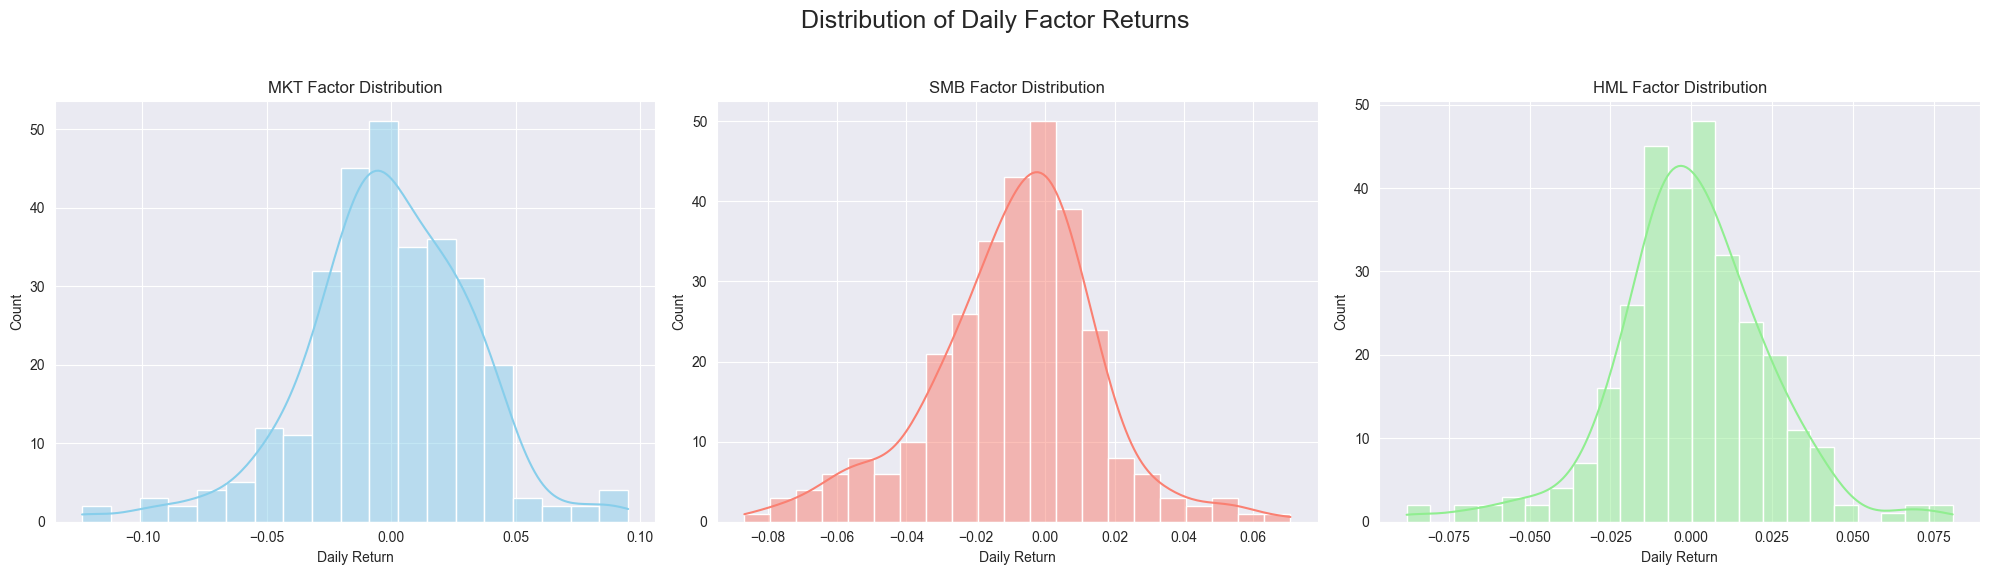


--- Interpretation Guide ---
 - Observe the shape of each distribution. Are they symmetric like a bell curve, or are they skewed?
 - Financial returns often have 'fat tails' (kurtosis), meaning extreme events are more common than a normal distribution would suggest.


In [5]:
# Cell: Factor Distribution Plots (Histograms and KDE)
print("--- Analyzing Factor Distributions ---")

# We will use the 'factors_df' DataFrame created previously
# If running independently, load the data first:
factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Daily Factor Returns', fontsize=18)

# Plot for MKT factor
sns.histplot(factors_df['MKT'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('MKT Factor Distribution')
axes[0].set_xlabel('Daily Return')

# Plot for SMB factor
sns.histplot(factors_df['SMB'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('SMB Factor Distribution')
axes[1].set_xlabel('Daily Return')

# Plot for HML factor
sns.histplot(factors_df['WML'], kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('HML Factor Distribution')
axes[2].set_xlabel('Daily Return')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("\n--- Interpretation Guide ---")
print(" - Observe the shape of each distribution. Are they symmetric like a bell curve, or are they skewed?")
print(" - Financial returns often have 'fat tails' (kurtosis), meaning extreme events are more common than a normal distribution would suggest.")

In [9]:
# Cell: Prepare Data for Market Cap Analysis

print("--- Preparing Data for Market Cap as Response Variable ---")

# 1. Load the factors and the full market cap data
try:
    factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    # Use the full_data_cache which has market caps for all assets
    market_cap_data = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# 2. Calculate the total market capitalization for each day
total_market_cap = market_cap_data.sum(axis=1)

# 3. Create the analysis DataFrame
mcap_analysis_df = pd.DataFrame(total_market_cap, columns=['Total_Market_Cap']).join(factors_df, how='inner')

# 4. Calculate log returns for the total market cap (our new 'y')
mcap_analysis_df['mcap_return'] = np.log(mcap_analysis_df['Total_Market_Cap']).diff()

# 5. Get risk-free rate and calculate excess returns
rf_rate = get_risk_free_rate(mcap_analysis_df.index.min(), mcap_analysis_df.index.max())
mcap_analysis_df['rf_rate'] = rf_rate['DTB3'].reindex(mcap_analysis_df.index, method='ffill').fillna(0)
mcap_analysis_df['mcap_excess_return'] = mcap_analysis_df['mcap_return'] - mcap_analysis_df['rf_rate']

mcap_analysis_df.dropna(inplace=True)

# 6. Define X, y, and scaled X
X_mcap = mcap_analysis_df[['MKT', 'SMB', 'WML']]
y_mcap = mcap_analysis_df['mcap_excess_return']

scaler_mcap = StandardScaler()
X_mcap_scaled = scaler_mcap.fit_transform(X_mcap)

print("Data for Market Cap analysis is prepared.")

--- Preparing Data for Market Cap as Response Variable ---
Data loaded successfully.
Fetching risk-free rate from FRED...
Data for Market Cap analysis is prepared.



--- Scatter Plots of Factors vs. Total Market Cap Return ---


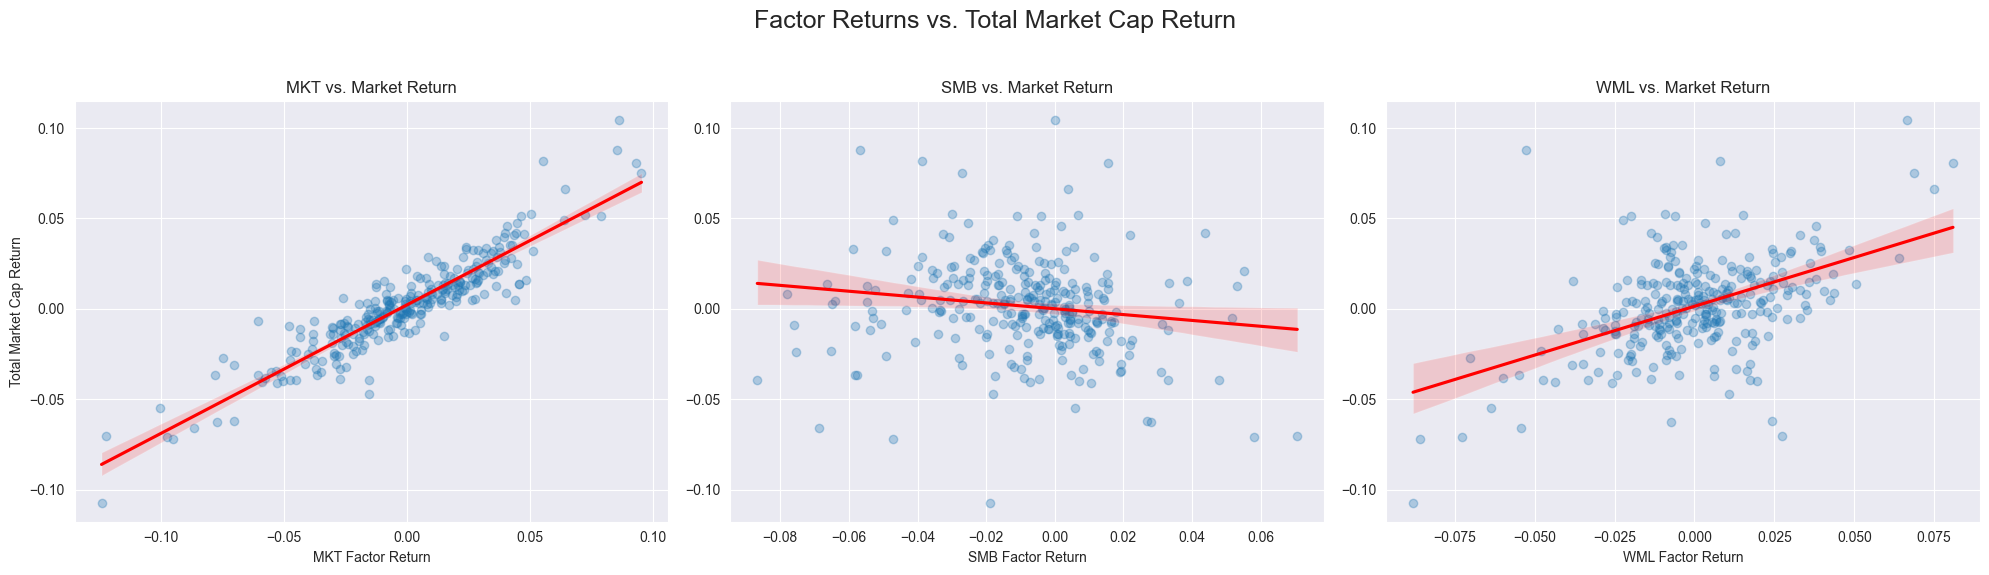


--- Interpretation Guide ---
 - The red line is the regression line, showing the linear trend.
 - MKT Plot: A strong, positive upward slope is expected, confirming the factor captures market movements.
 - SMB & HML Plots: A flat or near-flat regression line is ideal. This would confirm that the size and value factors are capturing sources of risk that are separate (uncorrelated) from the main market movement.


In [11]:
# Cell: Scatter Plots of Factors vs. Market Cap Returns

print("\n--- Scatter Plots of Factors vs. Total Market Cap Return ---")

# We will use the 'mcap_analysis_df' created in the comparative analysis part.
# It contains the factors and the market cap returns ('mcap_return').
# If running independently, you would need to recreate it first.

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Factor Returns vs. Total Market Cap Return', fontsize=18)

# 1. MKT vs. Market Cap Return
# We expect a very strong positive correlation here by definition.
sns.regplot(x='MKT', y='mcap_return', data=mcap_analysis_df, 
            ax=axes[0], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('MKT vs. Market Return')
axes[0].set_xlabel('MKT Factor Return')
axes[0].set_ylabel('Total Market Cap Return')


# 2. SMB vs. Market Cap Return
# We expect little to no correlation here.
sns.regplot(x='SMB', y='mcap_return', data=mcap_analysis_df, 
            ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('SMB vs. Market Return')
axes[1].set_xlabel('SMB Factor Return')
axes[1].set_ylabel('') # Hide y-label for clarity


# 3. HML vs. Market Cap Return
# We also expect little to no correlation here.
sns.regplot(x='WML', y='mcap_return', data=mcap_analysis_df, 
            ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('WML vs. Market Return')
axes[2].set_xlabel('WML Factor Return')
axes[2].set_ylabel('') # Hide y-label for clarity


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Interpretation Guide ---")
print(" - The red line is the regression line, showing the linear trend.")
print(" - MKT Plot: A strong, positive upward slope is expected, confirming the factor captures market movements.")
print(" - SMB & HML Plots: A flat or near-flat regression line is ideal. This would confirm that the size and value factors are capturing sources of risk that are separate (uncorrelated) from the main market movement.")


--- Scatter Plots of Factors vs. Total Market Cap ---


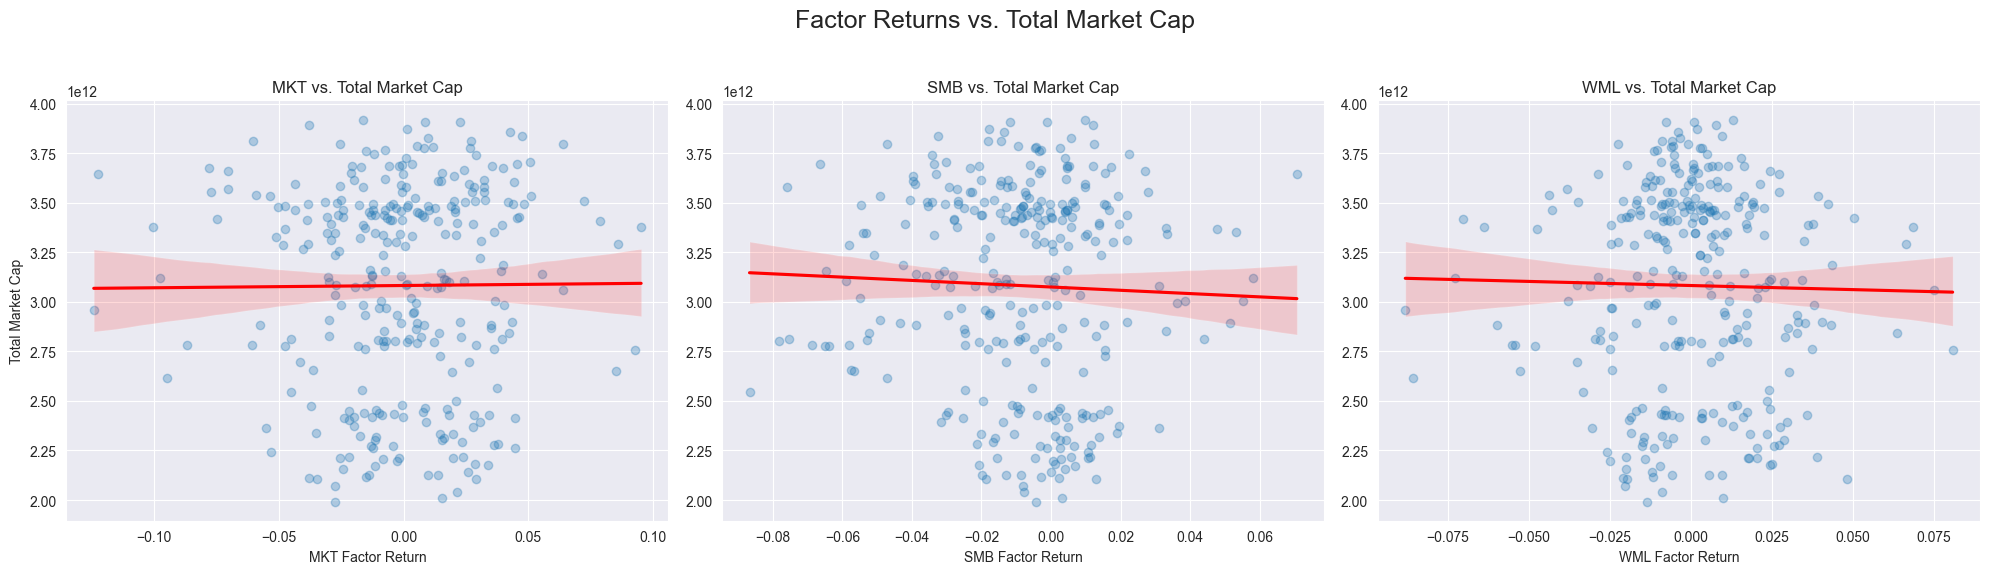


--- Interpretation Guide ---
 - The red line is the regression line, showing the linear trend.
 - MKT Plot: A strong, positive upward slope is expected, confirming the factor captures market movements.
 - SMB & HML Plots: A flat or near-flat regression line is ideal. This would confirm that the size and value factors are capturing sources of risk that are separate (uncorrelated) from the main market movement.


In [12]:
# Cell: Scatter Plots of Factors vs. Market Cap Returns

print("\n--- Scatter Plots of Factors vs. Total Market Cap ---")

# We will use the 'mcap_analysis_df' created in the comparative analysis part.
# It contains the factors and the market cap returns ('mcap_return').
# If running independently, you would need to recreate it first.

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Factor Returns vs. Total Market Cap', fontsize=18)

# 1. MKT vs. Market Cap Return
# We expect a very strong positive correlation here by definition.
sns.regplot(x='MKT', y='Total_Market_Cap', data=mcap_analysis_df, 
            ax=axes[0], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('MKT vs. Total Market Cap')
axes[0].set_xlabel('MKT Factor Return')
axes[0].set_ylabel('Total Market Cap')


# 2. SMB vs. Market Cap Return
# We expect little to no correlation here.
sns.regplot(x='SMB', y='Total_Market_Cap', data=mcap_analysis_df, 
            ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('SMB vs. Total Market Cap')
axes[1].set_xlabel('SMB Factor Return')
axes[1].set_ylabel('') # Hide y-label for clarity


# 3. HML vs. Market Cap Return
# We also expect little to no correlation here.
sns.regplot(x='WML', y='Total_Market_Cap', data=mcap_analysis_df, 
            ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('WML vs. Total Market Cap')
axes[2].set_xlabel('WML Factor Return')
axes[2].set_ylabel('') # Hide y-label for clarity


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Interpretation Guide ---")
print(" - The red line is the regression line, showing the linear trend.")
print(" - MKT Plot: A strong, positive upward slope is expected, confirming the factor captures market movements.")
print(" - SMB & HML Plots: A flat or near-flat regression line is ideal. This would confirm that the size and value factors are capturing sources of risk that are separate (uncorrelated) from the main market movement.")

In [10]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import sys

# Add the project root to the Python path to allow imports from src
# This assumes your notebook is in the 'notebooks' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import config
import pandas_datareader.data as web

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported and configuration loaded.")

Libraries imported and configuration loaded.


In [16]:
# Cell 2: Data Loading and Preparation

def get_risk_free_rate(start_date, end_date):
    """Fetches the 3-Month Treasury Bill Rate from FRED as the risk-free rate."""
    try:
        rf = web.DataReader('DTB3', 'fred', start_date, end_date)
        rf = rf.ffill() / 100 / 360
        return rf
    except Exception as e:
        return pd.Series(0, index=pd.date_range(start=start_date, end=end_date), name='DTB3')

def prepare_base_data():
    """
    Loads all necessary raw data, calculates base factors (MKT, SMB),
    and prepares the PCA index excess returns (our target variable).
    """
    print("Loading and preparing all necessary data...")
    try:
        # Load the three key data files
        market_caps = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)
        prices = pd.read_csv(config.DAILY_PRICE_FILE_PATH, index_col='Date', parse_dates=True)
        pca_index = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
        
        # Calculate daily returns from prices
        daily_returns = prices.pct_change().dropna(how='all')
        daily_returns.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Align all data to common dates and tickers
        common_dates = daily_returns.index.intersection(market_caps.index).intersection(pca_index.index)
        common_tickers = daily_returns.columns.intersection(market_caps.columns)
        
        daily_returns = daily_returns.loc[common_dates, common_tickers]
        market_caps = market_caps.loc[common_dates, common_tickers]
        pca_index = pca_index.loc[common_dates]

        # Calculate PCA index excess returns (our y variable)
        pca_log_returns = np.log(pca_index['Value']).diff()
        rf_rate = get_risk_free_rate(pca_log_returns.index.min(), pca_log_returns.index.max())
        rf = rf_rate['DTB3'].reindex(pca_log_returns.index, method='ffill').fillna(0)
        pca_excess_returns = pca_log_returns - rf

        # Calculate MKT factor
        market_return = daily_returns.mean(axis=1)
        mkt_factor = market_return - rf

        # Calculate SMB factor
        smb_list = []
        for date in daily_returns.index:
            mcaps_today = market_caps.loc[date].dropna()
            mcaps_today = mcaps_today[mcaps_today > 0]
            if len(mcaps_today) < 200:
                smb_list.append(0)
                continue
            sorted_mcaps = mcaps_today.sort_values(ascending=False)
            big_tickers = sorted_mcaps.head(100).index
            small_tickers = sorted_mcaps.tail(100).index
            smb_list.append(daily_returns.loc[date, small_tickers].mean() - daily_returns.loc[date, big_tickers].mean())
        smb_factor = pd.Series(smb_list, index=daily_returns.index)

        print("Data preparation complete.")
        return daily_returns, pca_excess_returns, mkt_factor, smb_factor

    except FileNotFoundError as e:
        print(f"ERROR: Missing data file. Please ensure all cache files exist. Missing: {e.filename}")
        return None, None, None, None

# Run the data preparation
daily_returns, y_target, mkt_factor, smb_factor = prepare_base_data()

Loading and preparing all necessary data...


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_9952/1314803912.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = prices.pct_change().dropna(how='all')


Data preparation complete.


In [17]:
# Cell 3: HML Calculation Function

def calculate_hml_with_quantile(daily_returns, quantile):
    """Calculates the HML factor for a given quantile split."""
    hml_list = []
    rebalance_dates = daily_returns.resample('M').last().index
    
    for i in range(1, len(rebalance_dates)):
        formation_date = rebalance_dates[i-1]
        start_of_prev_month = formation_date.to_period('M').start_time
        
        prev_month_returns = (daily_returns.loc[start_of_prev_month:formation_date] + 1).prod() - 1
        prev_month_returns = prev_month_returns.dropna()
        
        if len(prev_month_returns) < 10: continue

        # --- DYNAMIC QUANTILE ---
        q_low = prev_month_returns.quantile(quantile)
        q_high = prev_month_returns.quantile(1 - quantile)
        
        low_ret_tickers = prev_month_returns[prev_month_returns <= q_low].index
        high_ret_tickers = prev_month_returns[prev_month_returns >= q_high].index
        
        holding_period_start = formation_date + pd.Timedelta(days=1)
        holding_period_end = rebalance_dates[i]
        
        returns_next_month = daily_returns.loc[holding_period_start:holding_period_end]
        
        safe_low_tickers = low_ret_tickers.intersection(returns_next_month.columns)
        safe_high_tickers = high_ret_tickers.intersection(returns_next_month.columns)
        
        low_ret_returns = returns_next_month[safe_low_tickers].mean(axis=1)
        high_ret_returns = returns_next_month[safe_high_tickers].mean(axis=1)
        
        monthly_hml = low_ret_returns - high_ret_returns
        hml_list.append(monthly_hml)
        
    return pd.concat(hml_list)

In [24]:
# Cell 4: Sensitivity Analysis Loop and Results

# We will test splitting by the top/bottom 10%, 20%, 30%, and 40%
quantile_tests = [0.1, 0.2, 0.3, 0.4]
results = []

if y_target is not None: # Check if data loading was successful
    for q_val in quantile_tests:
        print(f"\n--- Testing HML with Top/Bottom {q_val:.0%} ---")
        
        # Calculate the new HML factor
        hml_new = calculate_hml_with_quantile(daily_returns, quantile=q_val)
        
        # Prepare data for OLS regression
        X_new = pd.DataFrame({'MKT': mkt_factor, 'SMB': smb_factor, 'HML': hml_new})
        
        # Align all data for the regression
        analysis_df = pd.concat([y_target.rename('pca_excess_return'), X_new], axis=1).dropna()
        y_reg = analysis_df['pca_excess_return']
        X_reg = sm.add_constant(analysis_df[['MKT', 'SMB', 'HML']])
        
        # Run the OLS regression
        model = sm.OLS(y_reg, X_reg).fit()
        print(model.rsquared_adj)
        # Store the key results
        results.append({
            'Quantile': f"{q_val:.0%}",
            'HML_Coefficient': model.params['HML'],
            'HML_PValue': model.pvalues['HML'],
            'Adj_R_squared': model.rsquared_adj
        })

    # --- Display the final comparison table ---
    results_df = pd.DataFrame(results).set_index('Quantile')

    print("\n--- HML Sensitivity Analysis Results ---")
    print(results_df)

    print("\n\n--- How to Interpret ---")
    print("Look for the row where the 'HML_PValue' is lowest (ideally below 0.05).")
    print("This indicates which definition of 'Value' and 'Growth' creates the most statistically significant factor for explaining your index's returns.")
else:
    print("Data could not be loaded. Cannot run analysis.")


--- Testing HML with Top/Bottom 10% ---
0.09374231532862409

--- Testing HML with Top/Bottom 20% ---
0.09151906938384435

--- Testing HML with Top/Bottom 30% ---
0.3171456518617055

--- Testing HML with Top/Bottom 40% ---
0.3369502758135362

--- HML Sensitivity Analysis Results ---
          HML_Coefficient    HML_PValue  Adj_R_squared
Quantile                                              
10%             -0.004438  2.897239e-01       0.093742
20%             -0.003445  6.120483e-01       0.091519
30%             -0.096371  9.690513e-24       0.317146
40%             -0.142642  5.158096e-26       0.336950


--- How to Interpret ---
Look for the row where the 'HML_PValue' is lowest (ideally below 0.05).
This indicates which definition of 'Value' and 'Growth' creates the most statistically significant factor for explaining your index's returns.


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_9952/2070928967.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample('M').last().index
/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_9952/2070928967.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample('M').last().index
/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_9952/2070928967.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample('M').last().index
/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_9952/2070928967.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample('M').last().index
